# Forward Seismic Modelling
## Exploring Fault Resolution

To start, you should read [THE BLOG POST].

### Objective

The ability for seismic to identify faults by their vertical offset has been raised on several occasions. Specifically, how much vertical offset must a fault cause to become recognizable on a seismic section? Studies of seismic's ability to resolve thin beds have established well-known limits for resolution: Widess criterion specifies an eighth wavelength; Raleigh Criterion specifies a quarter wavelength. However, neither of these are readily applicable to the question of fault offset. I hope the widget in this notebook will allow you to explore this.

## Get started

Set up this workspace:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import csv
#from scipy.interpolate import interp1d
#from scipy.signal import correlate
import LEtools # Log Edit tools saved in LEtools.py - this file must be in same directory as notebook
#from las import LASReader # las.py must be in same directory as notebook
import bruges # pip install bruges

from skimage.filters import gaussian
from skimage.util import random_noise

from ipywidgets import interact, interactive, interact_manual, FloatSlider, IntSlider, fixed, IntText, FloatLogSlider
import ipywidgets as widgets
from IPython.display import display
import matplotlib.patches as patches
from statistics import pvariance

#%  matplotlib inline

### References for Python and the libraries used here:

Hall, M., Bianco, E., Bougher, B., et al. (2013- ). Bruges: a bag of really useful geophysical equations and stuff (Python module), https://github.com/agile-geoscience/bruges, [online; accessed 2017-05-01]
Hunter, J. D. (2007), Matplotlib: A 2D graphics environment, Computing in Science & Engineering, 9, 90-95, doi:10.1109/MCSE.2007.55

Jones, E., Oliphant, E., Peterson, P., et al., (2001- ). SciPy: Open Source Scientific Tools for Python, http://www.scipy.org/, [online; accessed 2018-09-01].

Pérez, F., & Granger, B. E. (2007). IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29, doi:10.1109/MCSE.2007.53

van der Walt, S., Colbert, S. C., Varoquaux, G. (2011). The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30, doi:10.1109/MCSE.2011.37

Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) https://doi.org/10.7717/peerj.453

## Get started
Create synthetic sonic and density logs for a well.

In [2]:
# Density Log
DEN = np.zeros(500)
DEN[:250] = 2300
DEN[250:] = 2500

# Sonic Log
DT = np.zeros_like(DEN)
DT[:250] = 375 # ~2650 m/s
DT[250:] = 350 # ~2850 m/s

# Depth track
DEPTH = np.array(np.arange(0,100,0.2))

Look at the synthetic logs:

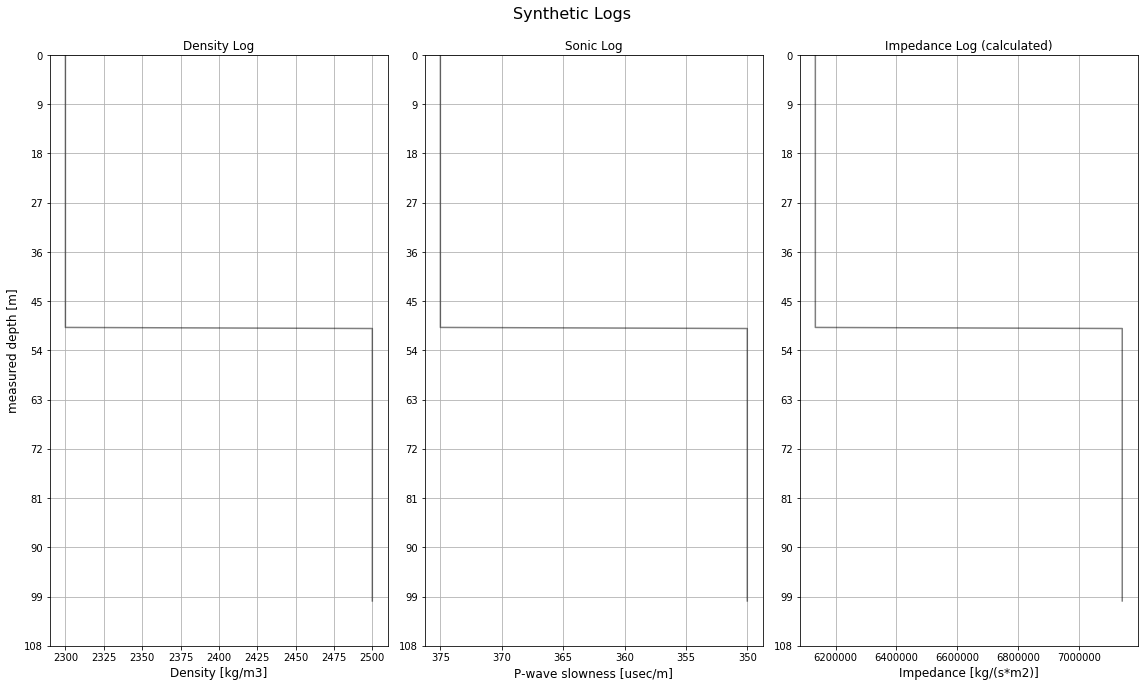

In [3]:
# Define the start and end elevations for plotting
start = 0
end = np.max(DEPTH)

gridinc = (end-start)//10

fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(16, 10))

# Density
axes[0].plot(DEN,DEPTH,'k-', alpha=0.5)

axes[0].set_title('Density Log')
axes[0].set_ylabel('measured depth [m]', fontsize = '12' )
axes[0].set_xlabel('Density [kg/m3]', fontsize = '12')

# Sonic
axes[1].plot(DT,DEPTH,'k-', alpha=0.5)
axes[1].invert_xaxis()
axes[1].set_title('Sonic Log')
axes[1].set_xlabel('P-wave slowness [usec/m]', fontsize = '12')

# Impedance
axes[2].plot(1e6*DEN/DT,DEPTH,'k-', alpha=0.5)

axes[2].set_title('Impedance Log (calculated)')
axes[2].set_xlabel('Impedance [kg/(s*m2)]', fontsize = '12')


# Format the axes, add pick notation
for i in range(3):
    axes[i].set_ylim((start//gridinc*gridinc),(end//gridinc*gridinc))
    axes[i].set_yticks(np.arange((start//gridinc*gridinc),((end//gridinc+2)*gridinc),gridinc))
    axes[i].invert_yaxis()
    axes[i].grid()



plt.suptitle('Synthetic Logs',fontsize=16)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Define a wavelet

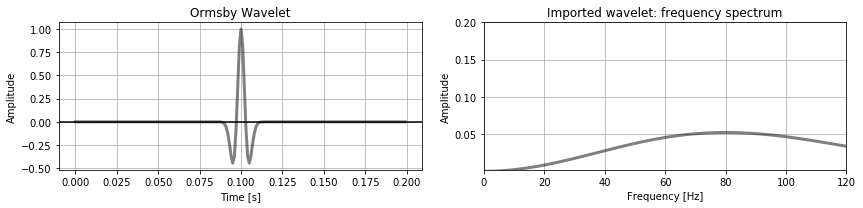

In [4]:
dt = 0.001 # sample rate in seconds
len_wav = 0.2 # length of wavelet in seconds

# Define the wavelet
#wav = bruges.filters.wavelets.ormsby(duration=len_wav,dt=dt,f=[8,16,40,80])
wav = bruges.filters.wavelets.ricker(duration=len_wav,dt=dt,f=80)

# Create a new time series for the wavelet

Twavestart = -(len_wav/dt-1)/2 * dt
Twaveend = (len_wav/dt-1)/2 * dt

Twav = np.arange(0,len_wav,dt)

# Use a Bag of Really Useful Geophysical Stuff to calculate the spectrum of the un-interpolated wavelet:
spec = bruges.attribute.spectrogram(wav,len(wav)-1,zero_padding=100)[0]

# Calculate the Nyquist frequency from the sample rate:
nyq = 0.5 * (1/dt) # samplerate is in seconds

# Plot

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(121)
ax.plot(Twav,wav,c='k',linewidth=3, alpha=0.5)
ax.axhline(y=0, c='k')
ax.set_title('Ormsby Wavelet')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.grid()

# plot the histogram
ax = fig.add_subplot(122)
ax.plot(np.arange(0,nyq,nyq/len(spec)),spec, c='k',linewidth=3, alpha=0.5) # np.arange(0,nyq,nyq/len(spec)) makes a freqency scale.
#ax.set_yscale('log')
plt.ylim((0.002,0.2))
plt.xlim((0,120))
ax.set_title('Imported wavelet: frequency spectrum')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.grid()

plt.tight_layout()

## Modelling




### Forward modelling

Forward modelling is an approach to understand the effect of changing geology on seismic response. Create a 2D synthetic model of _something_, changing thickness, for example, then convolve with a seismic wavelet to see how that change affects the reflectivity. These models demonstrate the effects of vertical offset of a fault.

First, demonstrate this concept by creating a model where a fault with vertical offset is present.

In [5]:
# Run this to create a time log. We're not interested in the time log, per se,
# but it is required to run the flow
TIME,DT_t,RC_t = LEtools.logs2RC_t(DEPTH,DEN,DT,dt)

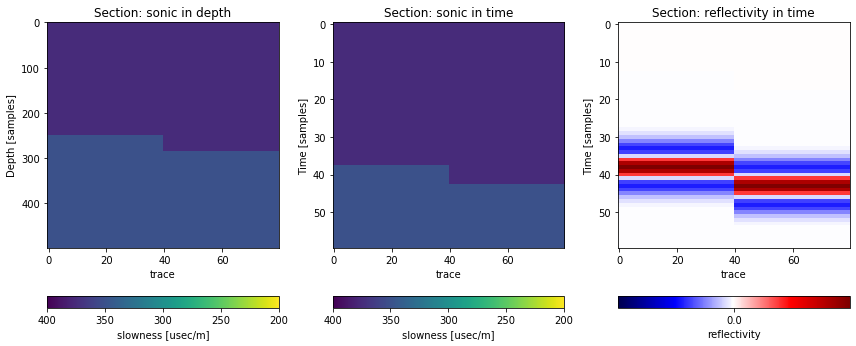

In [6]:
f_offset = 7

# Initialize an array to hold the wedge:
secRC = np.array([[]])
secDT = np.array([[]])
secDT_time = np.array([[]])

# Define left side of model
for i in range(0,40):

    # Modify logs - not changing these traces    
    # Thicken the DT log between 0m and 10m by 0m
    depth_interim, DT_interim = LEtools.LEthink(DEPTH,DT,0,10,0)
    depth_interim, DEN_interim = LEtools.LEthink(DEPTH,DEN,0,10,0)
    
    # Calculate reflectivity in time
    # Use Log Edit tools to calculate Reflectivity Coefficients and convert trace to time
    time_interim, DT_time, RC_interim = LEtools.logs2RC_t(depth_interim,
                                                          DEN_interim,
                                                          DT_interim,dt)
       
    # Append to section as new trace
    if i == 0: # if-else is used to deal with the case array is empty
        secRC = np.append(secRC,[RC_interim[:len(TIME)]],axis=1)
        secDT = np.append(secDT,[DT_interim[:len(DEPTH)]],axis=1)
        secDT_time = np.append(secDT_time,[DT_time[:len(TIME)]],axis=1)
    else:
        secRC = np.append(secRC,[RC_interim[:len(TIME)]],axis=0)
        secDT = np.append(secDT,[DT_interim[:len(DEPTH)]],axis=0)
        secDT_time = np.append(secDT_time,[DT_time[:len(TIME)]],axis=0)
        
        
# Define right side of model
for i in range(0,40):

    # Modify logs - add extra thickness to top of log    
    # Thicken the DT log between 0m and 10m by fault offset
    depth_interim, DT_interim = LEtools.LEthink(DEPTH,DT,0,10,f_offset)
    depth_interim, DEN_interim = LEtools.LEthink(DEPTH,DEN,0,10,f_offset)
    
    # Calculate reflectivity in time
    # Use Log Edit tools to calculate Reflectivity Coefficients and convert trace to time
    time_interim, DT_time, RC_interim = LEtools.logs2RC_t(depth_interim,
                                                          DEN_interim,
                                                          DT_interim,dt)
    
    # Append to section as new trace
    secRC = np.append(secRC,[RC_interim[:len(TIME)]],axis=0)
    secDT = np.append(secDT,[DT_interim[:len(DEPTH)]],axis=0)
    secDT_time = np.append(secDT_time,[DT_time[:len(TIME)]],axis=0)
    

# Convolve with wavelet

# Initialize empty array
sec_fault_synth = np.zeros_like(secRC)
# Populate array with reflectivity amplitude
for i in range(secRC.shape[0]):
    sec_fault_synth[i,:] = np.convolve(wav, np.nan_to_num(secRC[i,:]), mode='same')
    
# Extract the max amplitude from the synthetic - used for scaling plots
synthAMPmax = 1.0 * max(np.amax(sec_fault_synth),abs(np.amin(sec_fault_synth)))




# Plot a figure

#Plot

fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(12, 5))

# Sonic in depth
im = axes[0].imshow(secDT[:,:].T, vmin=200, vmax=400, cmap="viridis_r", aspect='auto')
axes[0].set_title('Section: sonic in depth')
axes[0].set_ylabel('Depth [samples]')
cbar = fig.colorbar(im, ax=axes[0],ticks=range(200,401,50),orientation='horizontal')
cbar.ax.invert_xaxis()
cbar.set_label('slowness [usec/m]')

# Sonic in time
im = axes[1].imshow(secDT_time[:,:60].T, vmin=200, vmax=400, cmap="viridis_r", aspect='auto')
axes[1].set_title('Section: sonic in time')
axes[1].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[1],ticks=range(200,401,50),orientation='horizontal')
cbar.ax.invert_xaxis()
cbar.set_label('slowness [usec/m]')

# Wavelet seismic in time
im = axes[2].imshow(sec_fault_synth[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[2].set_title('Section: reflectivity in time')
axes[2].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[2], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Label x axis for first three plots
for i in range(3):
    axes[i].set_xlabel('trace')



plt.tight_layout()

## Adding random noise

There's always random noise in seismic. Try adding some to make this more realistic.

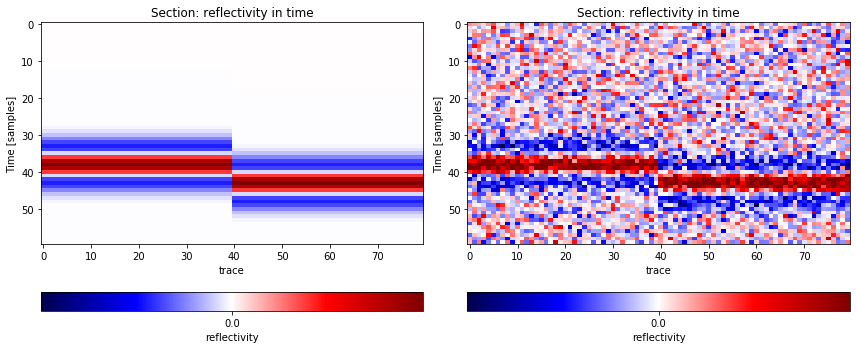

In [7]:
# Add noise to the image
sec_fault_synth_noise = random_noise(sec_fault_synth, mode='gaussian', var=0.0003)

# Plot to compare
#Plot

fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12, 5))

# Wavelet seismic in time
im = axes[0].imshow(sec_fault_synth[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[0].set_title('Section: reflectivity in time')
axes[0].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[0], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Wavelet seismic in time
im = axes[1].imshow(sec_fault_synth_noise[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[1].set_title('Section: reflectivity in time')
axes[1].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[1], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Label x axis for first three plots
for i in range(2):
    axes[i].set_xlabel('trace')



plt.tight_layout()


Alternative approach, add noise to model and then convolve with wavelet:

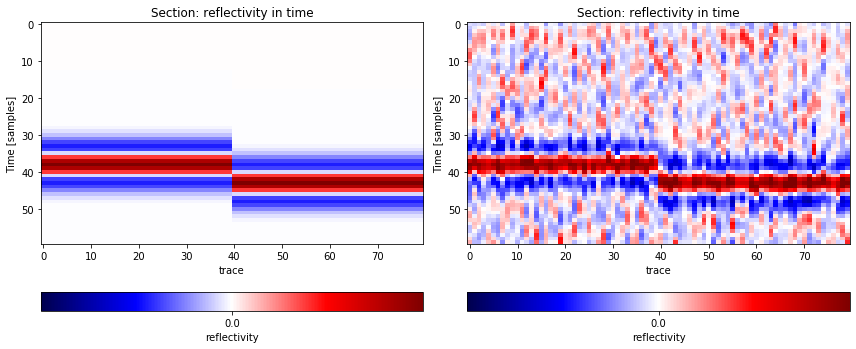

In [8]:
# Add noise to model:
secRC_noise = random_noise(secRC, mode='gaussian', var=0.0001)

# Initialize empty array
sec_fault_noise_synth = np.zeros_like(secRC)
# Populate array with reflectivity amplitude
for i in range(secRC.shape[0]):
    sec_fault_noise_synth[i,:] = np.convolve(wav, np.nan_to_num(secRC_noise[i,:]), mode='same')
    

    # Plot to compare
#Plot

fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12, 5))

# Wavelet seismic in time
im = axes[0].imshow(sec_fault_synth[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[0].set_title('Section: reflectivity in time')
axes[0].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[0], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Wavelet seismic in time
im = axes[1].imshow(sec_fault_noise_synth[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[1].set_title('Section: reflectivity in time')
axes[1].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[1], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Label x axis for first three plots
for i in range(2):
    axes[i].set_xlabel('trace')



plt.tight_layout()

## Add some consideration for lateral resolution

For the models so far, the lateral resolution is exactly the trace spacing. However, in practice, the lateral resolution is some multiple of trace spacing. I will simulate this effect by "smearing" across traces at each time sample.

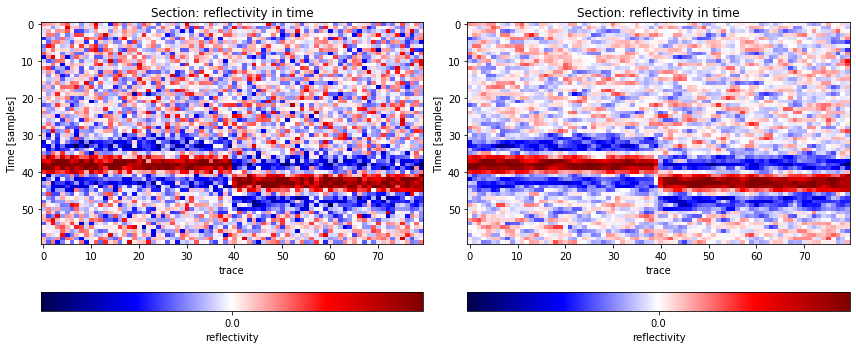

In [9]:
# Filter an image:
sec_fault_synth_noise_filt = gaussian(sec_fault_synth_noise,
                                      sigma=[0.75,0], mode='reflect',
                                      preserve_range=True)


# Plot to compare
#Plot

fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12, 5))

# Wavelet seismic in time
im = axes[0].imshow(sec_fault_synth_noise[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[0].set_title('Section: reflectivity in time')
axes[0].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[0], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Wavelet seismic in time
im = axes[1].imshow(sec_fault_synth_noise_filt[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[1].set_title('Section: reflectivity in time')
axes[1].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[1], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Label x axis for first three plots
for i in range(2):
    axes[i].set_xlabel('trace')



plt.tight_layout()

Well, now that I see the combination of lateral smoothing and gaussian noise applied to the synnthetic, I dont' like the result. Applying gaussian noise to the model before convolution with the wavelet creates a more seismic-like result.

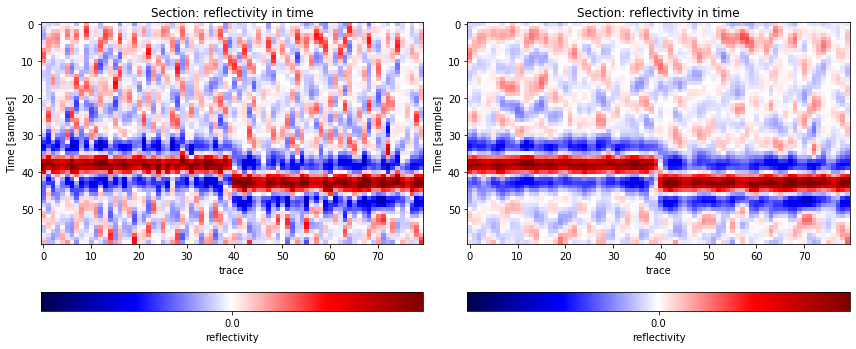

In [10]:
# Filter an image:
sec_fault_noise_synth_filt = gaussian(sec_fault_noise_synth,
                                      sigma=[0.75,0], mode='reflect',
                                      preserve_range=True)


# Plot to compare
#Plot

fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12, 5))

# Wavelet seismic in time
im = axes[0].imshow(sec_fault_noise_synth[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[0].set_title('Section: reflectivity in time')
axes[0].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[0], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Wavelet seismic in time
im = axes[1].imshow(sec_fault_noise_synth_filt[:,:60].T, vmin=-synthAMPmax, vmax=synthAMPmax, cmap="seismic", aspect='auto')
axes[1].set_title('Section: reflectivity in time')
axes[1].set_ylabel('Time [samples]')
cbar = fig.colorbar(im, ax=axes[1], ticks=[-.3,0,.3], orientation='horizontal')
cbar.set_label('reflectivity')

# Label x axis for first three plots
for i in range(2):
    axes[i].set_xlabel('trace')



plt.tight_layout()

## Wrap it up in a function

I'd like to create a funtion for this. Maybe even a widget!

Key inputs are:
* Wavelet (Ormsby corner frequencies)
* fault offset
* noise
* lateral smoothing

In [15]:
def fault_model(freq,f_offset,noise_var,lat_smooth,DEPTH,DEN,DT,dt=0.001,len_wav=0.2):
    """
    Function to demonstrate the visibility of faults. Generates a plot.
    
       
    #corner_freqs  =  list of four corner frequencies for Ormsby wavelet [f1,f2,f3,f4]
    freq          =  central frequency of Ricker wavelet
    f_offset      =  vertical offset of the modelled fault
    noise_var     =  variance of random noise (= (standard deviation)**2). Best >> 1
    lat_smooth    =  lateral smoothing defined as standard deviation for gaussian kernal.
    DEPTH         =  Depth log
    DEN           =  Density log
    DT            =  Sonic log
    dt            =  sample rate in seconds for modelling and wavelet (default=0.001)
    len_wav       =  length in seconds for wavelet (default = 0.2)
    
    """
    
    # Define the wavelet
    
    #wav = bruges.filters.wavelets.ormsby(duration=len_wav,dt=dt,f=corner_freqs)
    wav = bruges.filters.wavelets.ricker(duration=len_wav,dt=dt,f=freq)
    wavelength = np.sqrt(6)/(np.pi*freq)* 1e6 /DT[0] /2

    # Create a new time series for the wavelet - may not use it, but it's here
    Twavestart = -(len_wav/dt-1)/2 * dt
    Twaveend = (len_wav/dt-1)/2 * dt

    Twav = np.arange(0,len_wav,dt)

    # Use a Bag of Really Useful Geophysical Stuff to calculate the spectrum of the un-interpolated wavelet:
    spec = bruges.attribute.spectrogram(wav,len(wav)-1,zero_padding=100)[0]

    # Calculate the Nyquist frequency from the sample rate:
    nyq = 0.5 * (1/dt) # samplerate is in seconds
    
    
    # Run TIME
    
    # Run this to create a time log. We're not interested in the time log, per se,
    # but it is required to run the flow
    TIME,DT_t,RC_t = LEtools.logs2RC_t(DEPTH,DEN,DT,dt)
    
    
    # Create model

    # Initialize an array to hold the wedge:
    secRC = np.array([[]])
    secDT = np.array([[]])
    secDT_time = np.array([[]])

    # Define left side of model
    for i in range(0,40):

        # Modify logs - not changing these traces    
        # Thicken the DT log between 0m and 10m by 0m
        depth_interim, DT_interim = LEtools.LEthink(DEPTH,DT,0,10,0)
        depth_interim, DEN_interim = LEtools.LEthink(DEPTH,DEN,0,10,0)

        # Calculate reflectivity in time
        # Use Log Edit tools to calculate Reflectivity Coefficients and convert trace to time
        time_interim, DT_time, RC_interim = LEtools.logs2RC_t(depth_interim,
                                                              DEN_interim,
                                                              DT_interim,dt)

        # Append to section as new trace
        if i == 0: # if-else is used to deal with the case array is empty
            secRC = np.append(secRC,[RC_interim[:len(TIME)]],axis=1)
            secDT = np.append(secDT,[DT_interim[:len(DEPTH)]],axis=1)
            secDT_time = np.append(secDT_time,[DT_time[:len(TIME)]],axis=1)
        else:
            secRC = np.append(secRC,[RC_interim[:len(TIME)]],axis=0)
            secDT = np.append(secDT,[DT_interim[:len(DEPTH)]],axis=0)
            secDT_time = np.append(secDT_time,[DT_time[:len(TIME)]],axis=0)


    # Define right side of model
    for i in range(0,40):

        # Modify logs - add extra thickness to top of log    
        # Thicken the DT log between 0m and 10m by fault offset
        depth_interim, DT_interim = LEtools.LEthink(DEPTH,DT,0,10,f_offset)
        depth_interim, DEN_interim = LEtools.LEthink(DEPTH,DEN,0,10,f_offset)

        # Calculate reflectivity in time
        # Use Log Edit tools to calculate Reflectivity Coefficients and convert trace to time
        time_interim, DT_time, RC_interim = LEtools.logs2RC_t(depth_interim,
                                                              DEN_interim,
                                                              DT_interim,dt)

        # Append to section as new trace
        secRC = np.append(secRC,[RC_interim[:len(TIME)]],axis=0)
        secDT = np.append(secDT,[DT_interim[:len(DEPTH)]],axis=0)
        secDT_time = np.append(secDT_time,[DT_time[:len(TIME)]],axis=0)

        
    # Add noise
    
    # Add noise to RC model:
    secRC_noise = random_noise(secRC, mode='gaussian', var=noise_var)

       
    # Convolve with wavelet
    
    # Initialize empty array
    sec_fault_synth = np.zeros_like(secRC_noise)
    # Populate array with reflectivity amplitude
    for i in range(secRC.shape[0]):
        sec_fault_synth[i,:] = np.convolve(wav, np.nan_to_num(secRC_noise[i,:]), mode='same')

    # Extract the max amplitude from the synthetic - used for scaling plots
    synthAMPmax = 1.0 * max(np.amax(sec_fault_synth),abs(np.amin(sec_fault_synth)))
    
    
    # Lateral smoothing
    
    sec_fault_synth_filt = gaussian(sec_fault_synth,
                                      sigma=[lat_smooth,0], mode='reflect',
                                      preserve_range=True)
    
    
    # Calculate signal to noise ratio
    
    #SNR = Variance(signal) / (Variance(signal + noise) - Variance(signal))
    # Need Variance of signal: variance of one trace is same as whole section
    var_signal = pvariance(np.convolve(wav, np.nan_to_num(secRC[0]), mode='same'))
    
    # Now calculate the ratio                       
    snr = var_signal / (pvariance(sec_fault_synth_filt.tolist()[0])- var_signal)
    
    
    # Plot spectrogram, model in depth, model in time, final synthetic
    
    #Plot Wavelet
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(321)
    ax.plot(Twav,wav,c='k',linewidth=3, alpha=0.5)
    ax.axhline(y=0, c='k')
    ax.set_title('Ricker Wavelet')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude')
    ax.grid()

    # plot the histogram
    ax = fig.add_subplot(322)
    ax.plot(np.arange(0,nyq,nyq/len(spec)),spec, c='k',linewidth=3, alpha=0.5) # np.arange(0,nyq,nyq/len(spec)) makes a freqency scale.
    #ax.set_yscale('log')
    plt.ylim((0.002,0.2))
    plt.xlim((0,2*freq))
    ax.set_title('Imported wavelet: frequency spectrum')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude')
    ax.grid()
    
    # Sonic in depth
    ax = fig.add_subplot(234)
    im = ax.imshow(secDT[:,:].T, vmin=200, vmax=400,
                   cmap="viridis_r", aspect='auto')
    ax.set_title('Section: sonic in depth')
    ax.set_ylabel('Depth [samples]')
    ax.set_xlabel('trace')
    cbar = fig.colorbar(im, ax=ax,ticks=range(200,401,50),orientation='horizontal')
    cbar.ax.invert_xaxis()
    cbar.set_label('slowness [usec/m]')

    # Sonic in time
    ax = fig.add_subplot(235)
    im = ax.imshow(secDT_time[:,:75].T, vmin=200, vmax=400,
                   cmap="viridis_r", aspect='auto')
    ax.set_title('Section: sonic in time')
    ax.set_ylabel('Time [samples]')
    ax.set_xlabel('trace')
    cbar = fig.colorbar(im, ax=ax,ticks=range(200,401,50),orientation='horizontal')
    cbar.ax.invert_xaxis()
    cbar.set_label('slowness [usec/m]')
    
    # Add some text:
    ax.text(-20,-30,'Fault offset is ' + r'$\lambda/ %s$' % np.round(wavelength/f_offset,1), fontsize=30)
    ax.text(-20,-20,'Signal to noise ratio is %s' % np.round(snr,2), fontsize=20)

    # Wavelet seismic in time
    ax = fig.add_subplot(236)
    im = ax.imshow(sec_fault_synth_filt[:,:75].T,
                   vmin=-synthAMPmax, vmax=synthAMPmax,
                   cmap="seismic", aspect='auto')
    ax.set_title('Section: reflectivity in time')
    ax.set_ylabel('Time [samples]')
    ax.set_xlabel('trace')
    cbar = fig.colorbar(im, ax=ax, ticks=[-.1,0,.1], orientation='horizontal')
    cbar.set_label('reflectivity')


    #plt.tight_layout()
    

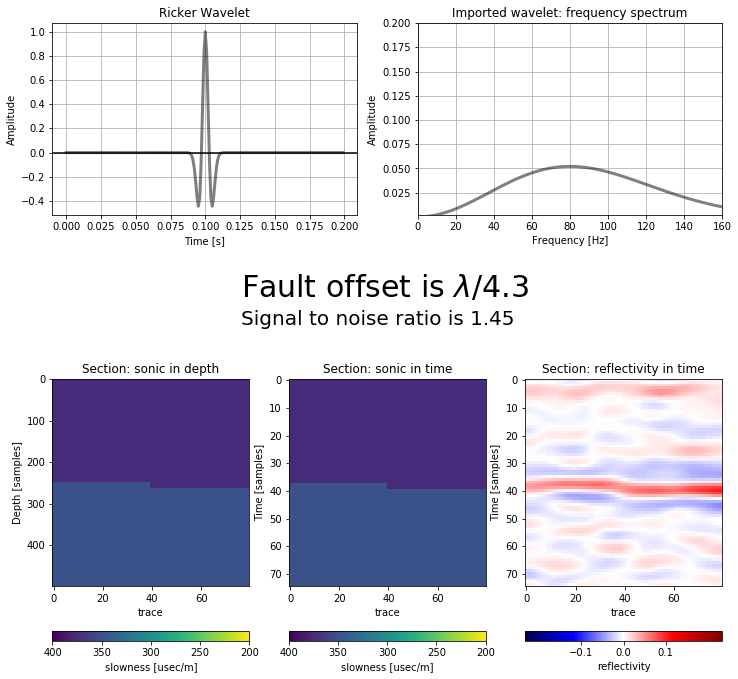

In [16]:
fault_model(freq=80,f_offset=3,noise_var=0.001,lat_smooth=5,DEPTH=DEPTH,DEN=DEN,DT=DT,dt=0.001,len_wav=0.2)

In [17]:
rslt = interactive(fault_model, freq=IntSlider(min=10, max=150, step=2, description='Frequency', value=60, continuous_update=False),
                   f_offset=IntSlider(min=0, max=20, step=1, description='Fault Offset', value = 10, continuous_update=False),
                   noise_var=FloatLogSlider(value=0.001, base=10, min=-6, max=-1, description='Noise Var.', continuous_update=False),
                   lat_smooth=IntSlider(min=0, max=10, step=1, value=3, description='Lat. Smooth', continuous_update=False),
                   DEPTH=fixed(DEPTH), DEN=fixed(DEN), DT=fixed(DT),
                   dt=fixed(0.001),len_wav=fixed(0.2))

In [18]:
display(rslt)

interactive(children=(IntSlider(value=60, continuous_update=False, description='Frequency', max=150, min=10, s…

### Figure: offset of lamda/1000

<ipython-input-15-6200423c86b6>:129: RuntimeWarning: divide by zero encountered in double_scalars
  snr = var_signal / (pvariance(sec_fault_synth_filt.tolist()[0])- var_signal)


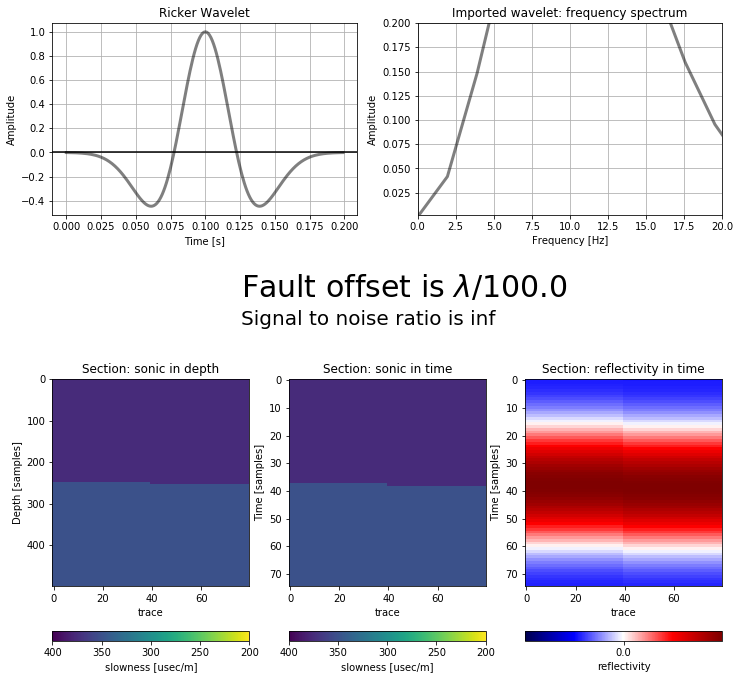

In [40]:
fault_model(freq=10,f_offset=1.04,
            noise_var=0.00,
            lat_smooth=0,
            DEPTH=DEPTH,DEN=DEN,DT=DT,
            dt=0.001,len_wav=0.2)

### Figure showing the effect of noise

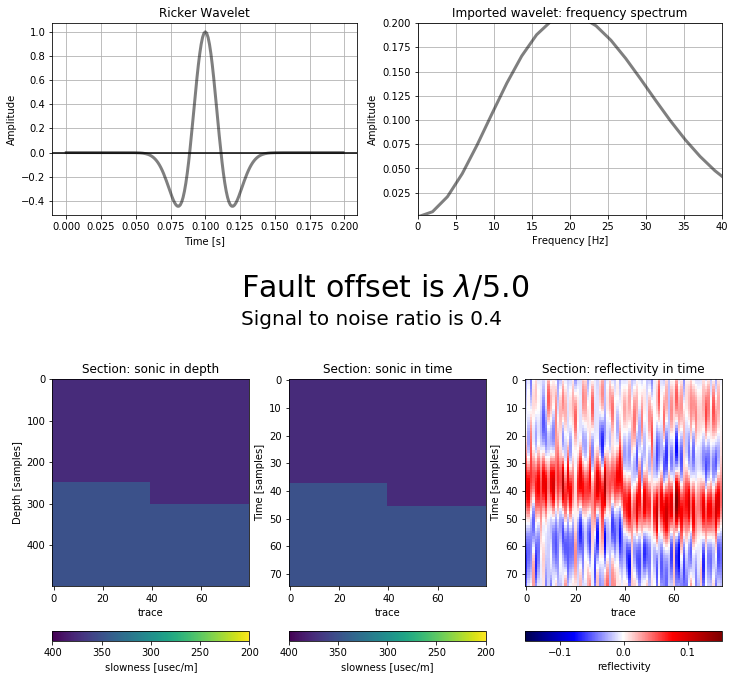

In [48]:
fault_model(freq=20,f_offset=10.5,
            noise_var=0.0001,
            lat_smooth=0,
            DEPTH=DEPTH,DEN=DEN,DT=DT,
            dt=0.001,len_wav=0.2)

### Figure lateral smoothing

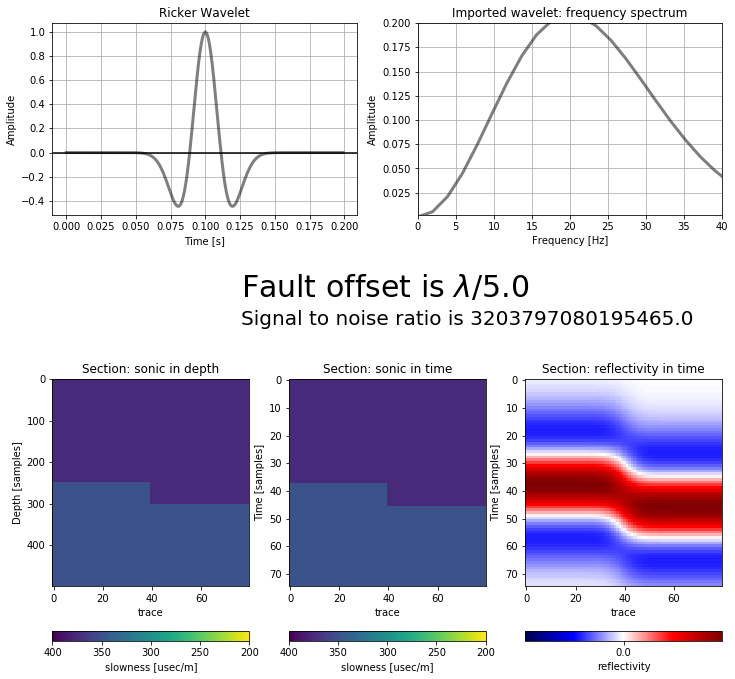

In [49]:
fault_model(freq=20,f_offset=10.5,
            noise_var=0.000,
            lat_smooth=5,
            DEPTH=DEPTH,DEN=DEN,DT=DT,
            dt=0.001,len_wav=0.2)

### Figure showing same fault without smoothing or noise

<ipython-input-15-6200423c86b6>:129: RuntimeWarning: divide by zero encountered in double_scalars
  snr = var_signal / (pvariance(sec_fault_synth_filt.tolist()[0])- var_signal)


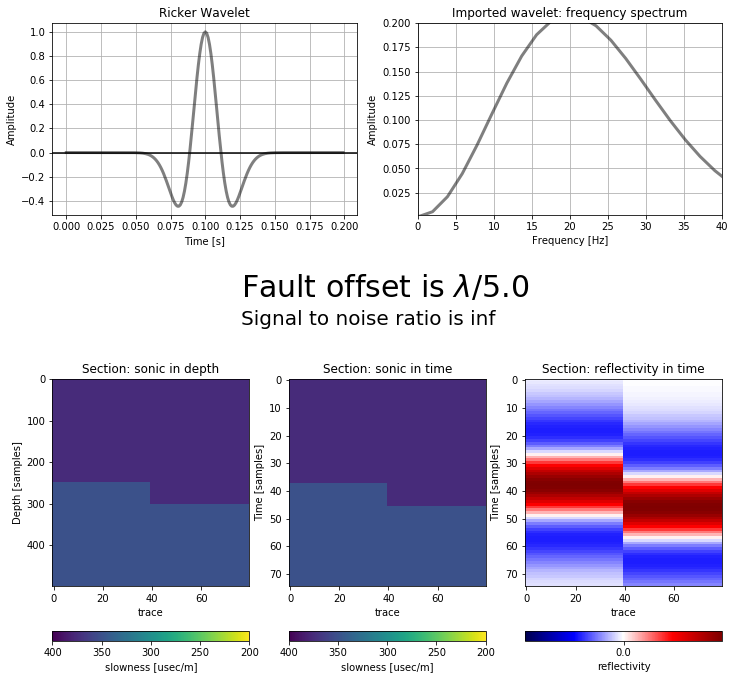

In [50]:
fault_model(freq=20,f_offset=10.5,
            noise_var=0.000,
            lat_smooth=0,
            DEPTH=DEPTH,DEN=DEN,DT=DT,
            dt=0.001,len_wav=0.2)

### Figure showing both noise and smoothing

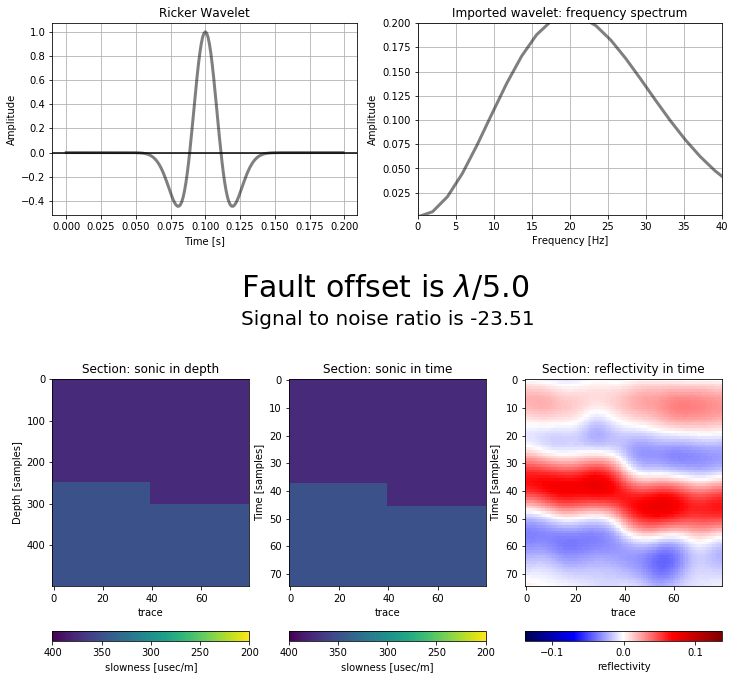

In [51]:
fault_model(freq=20,f_offset=10.5,
            noise_var=0.0001,
            lat_smooth=5,
            DEPTH=DEPTH,DEN=DEN,DT=DT,
            dt=0.001,len_wav=0.2)